In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Load data

In [158]:
df = pd.read_csv("https://raw.githubusercontent.com/Dee-M123/Africa-Economic-Banking-and-Systemic-Crisis/refs/heads/main/Data/cleaned/african_crises_cleaned.csv")

df.head(3)


,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0


The created oulier subsets

In [159]:
def get_iqr_bounds(series):

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR

    upper = Q3 + 1.5 * IQR

    return lower, upper

In [160]:
# Exchange Rate Outlier Subset
lower, upper = get_iqr_bounds(df['exch_usd'])

exchange_outliers = df[(df['exch_usd'] < lower) |(df['exch_usd'] > upper)]

exchange_normal = df[(df['exch_usd'] >= lower) & (df['exch_usd'] <= upper)]



In [161]:
# GDP Weighted Default Outliers

lower, upper = get_iqr_bounds(df['gdp_weighted_default'])

gdp_outliers = df[(df['gdp_weighted_default'] < lower) |(df['gdp_weighted_default'] > upper)]

gdp_normal = df[(df['gdp_weighted_default'] >= lower) & (df['gdp_weighted_default'] <= upper)]

In [162]:
# Inflation Outlier Subset
lower, upper = get_iqr_bounds(df['inflation_annual_cpi'])

inflation_outliers = df[(df['inflation_annual_cpi'] < lower) |(df['inflation_annual_cpi'] > upper)]

inflation_normal = df[(df['inflation_annual_cpi'] >= lower) & (df['inflation_annual_cpi'] <= upper)]

# **What macroeconomic conditions increase sovereign default risk?**

H0: Inflation has no effect on sovereign default probability.

H1: Higher inflation significantly increases the probability of sovereign external debt default

**Inflation during default without accounting for outliers**

In [163]:
# checking for correlation between default and inflation
df[['inflation_annual_cpi','sovereign_external_debt_default']].corr()

,inflation_annual_cpi,sovereign_external_debt_default
inflation_annual_cpi,1.000000,0.072609
sovereign_external_debt_default,0.072609,1.000000


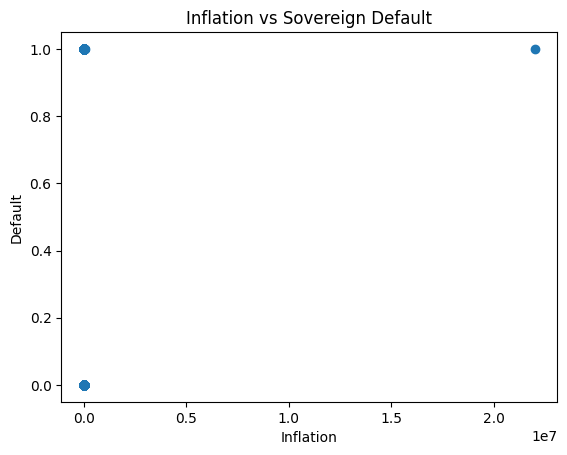

In [164]:
plt.figure()
plt.scatter(df['inflation_annual_cpi'],df['sovereign_external_debt_default'])
plt.title("Inflation vs Sovereign Default")
plt.xlabel("Inflation")
plt.ylabel("Default")
plt.show()

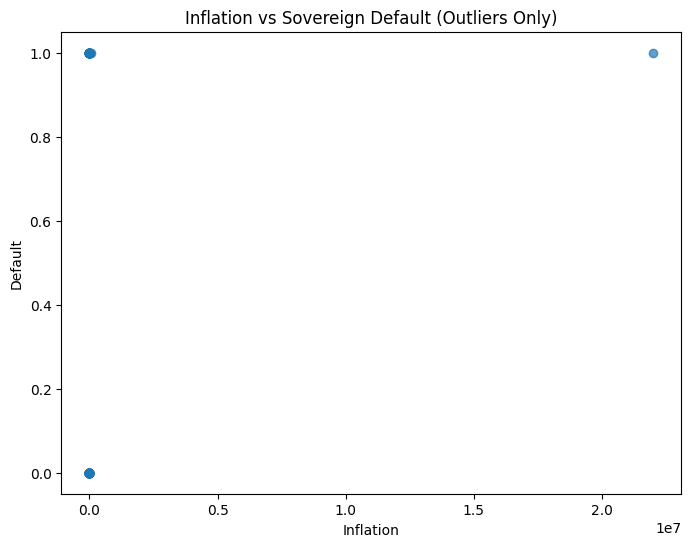

In [165]:
plt.figure(figsize=(8,6))

plt.scatter(inflation_outliers['inflation_annual_cpi'],
            inflation_outliers['sovereign_external_debt_default'],
            alpha=0.7)

plt.title("Inflation vs Sovereign Default (Outliers Only)")
plt.xlabel("Inflation")
plt.ylabel("Default")
plt.show()

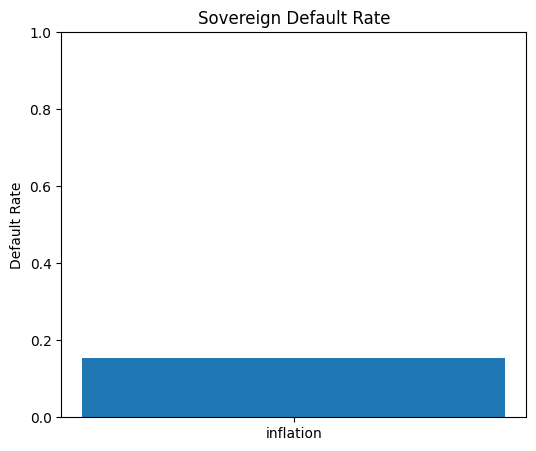

In [166]:
plt.figure(figsize=(6,5))

default_rate = df['sovereign_external_debt_default'].mean()

plt.bar(['inflation'], [default_rate])

plt.title("Sovereign Default Rate")
plt.ylabel("Default Rate")
plt.ylim(0,1)

plt.show()

Normal inflation, without outliers

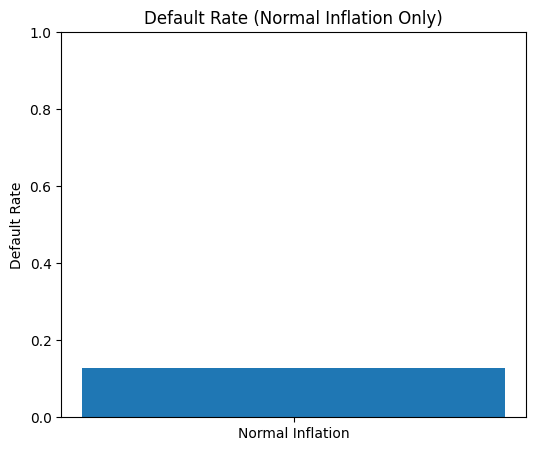

In [167]:
plt.figure(figsize=(6,5))

normal_default_rate = inflation_normal['sovereign_external_debt_default'].mean()

plt.bar(['Normal Inflation'], [normal_default_rate])

plt.title("Default Rate (Normal Inflation Only)")
plt.ylabel("Default Rate")
plt.ylim(0,1)

plt.show()

In [168]:
inflation_normal[['inflation_annual_cpi','sovereign_external_debt_default']].corr()

,inflation_annual_cpi,sovereign_external_debt_default
inflation_annual_cpi,1.000000,-0.005294
sovereign_external_debt_default,-0.005294,1.000000


With only outliers

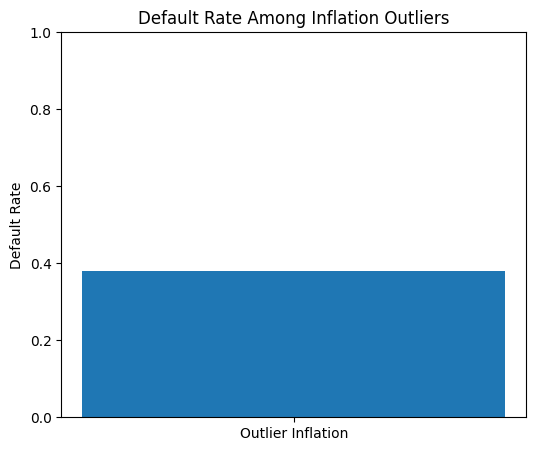

In [169]:
default_rate = inflation_outliers['sovereign_external_debt_default'].mean()

plt.figure(figsize=(6,5))
plt.bar(['Outlier Inflation'], [default_rate])

plt.title("Default Rate Among Inflation Outliers")
plt.ylabel("Default Rate")
plt.ylim(0,1)
plt.show()

In [170]:
inflation_outliers[['inflation_annual_cpi','sovereign_external_debt_default']].corr()

,inflation_annual_cpi,sovereign_external_debt_default
inflation_annual_cpi,1.000000,0.124035
sovereign_external_debt_default,0.124035,1.000000


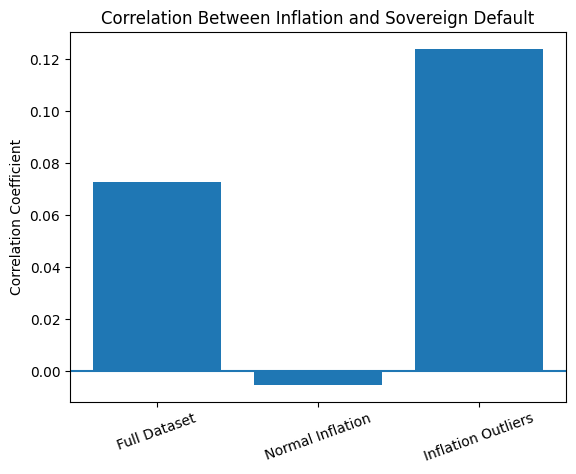

In [171]:
labels = ['Full Dataset', 'Normal Inflation', 'Inflation Outliers']
correlations = [0.0726, -0.0053, 0.1240]

plt.figure()
plt.bar(labels, correlations)
plt.axhline(0)
plt.title("Correlation Between Inflation and Sovereign Default")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=20)
plt.show()

# Results from first business question

Inflation vs Default:
- With the Full dataset, correlation is 0.0726, positve but very weak correlation. Meaning inflation on it's would not drive default.

- Normal inflation (without ouliers) only has a correlation of	-0.0053, meaning regualr inflation range is not associated with defaults.

- Inflation outliers have a correlation of 0.1240, meaning a moderate relationship indicates defaults occuring during extreme inflation years.

Test for statistical significance of results

In [172]:
# FULL DATASET — P-VALUE

from scipy.stats import mannwhitneyu

p_value = mannwhitneyu(
    df[df['sovereign_external_debt_default'] == 1]['inflation_annual_cpi'],
    df[df['sovereign_external_debt_default'] == 0]['inflation_annual_cpi']
).pvalue

print("P-value:", p_value)

P-value: 0.00011061813375657597


In [173]:
#normal inflation range

p_normal = mannwhitneyu(
    inflation_normal[inflation_normal['sovereign_external_debt_default'] == 1]['inflation_annual_cpi'],
    inflation_normal[inflation_normal['sovereign_external_debt_default'] == 0]['inflation_annual_cpi']
).pvalue

print("Normal subset p-value:", p_normal)

Normal subset p-value: 0.4945789996576684


In [174]:
# outliers
p_outliers = mannwhitneyu(
    inflation_outliers[inflation_outliers['sovereign_external_debt_default'] == 1]['inflation_annual_cpi'],
    inflation_outliers[inflation_outliers['sovereign_external_debt_default'] == 0]['inflation_annual_cpi']
).pvalue

print("Outliers subset p-value:", p_outliers)

Outliers subset p-value: 2.1582195967851683e-10


- **Full datset is significat but driven by extreme spikes (outliers)**
- **Normal inflation range is not significant, no difference between default and non-default**
- **inflation outliers produce extremely significant stats, confirm default risk in high inflation periods**.


# **Which historical period was most economically unstable?**

H0: Crisis events and inflation are evenly distributed across decades.

H2: The 1980s - 1990s experienced significantly higher inflation and crisis frequency compared to other decades

Define decade variable

In [175]:
df['decade'] = (df['year'] // 10) * 10

In [176]:
df['decade'].unique()

array([1870, 1880, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010,
       1920, 1860, 1890, 1900, 1910])

Inflation by decade

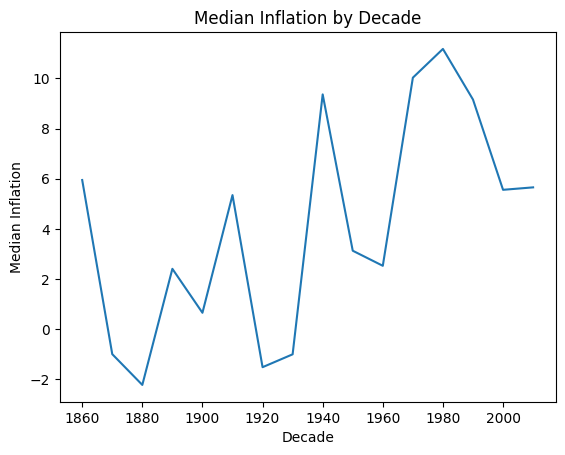

In [177]:
inflation_by_decade = df.groupby('decade')['inflation_annual_cpi'].median()

plt.figure()
plt.plot(inflation_by_decade.index, inflation_by_decade.values)
plt.title("Median Inflation by Decade")
plt.xlabel("Decade")
plt.ylabel("Median Inflation")
plt.show()

In [178]:
from scipy.stats import kruskal

groups = [group['inflation_annual_cpi'].values
          for name, group in df.groupby('decade')]

stat, p_value = kruskal(*groups)

print("Kruskal-Wallis p-value (inflation across decades):", p_value)

Kruskal-Wallis p-value (inflation across decades): 5.105684676415649e-59


Crisis probability across decades

In [179]:
df.groupby('decade')[['banking_crisis','systemic_crisis','sovereign_external_debt_default']].mean()*100

country_decade = df.groupby(['country','decade'])[
    ['banking_crisis','systemic_crisis','sovereign_external_debt_default']
].mean() * 100

country_decade = country_decade.reset_index()

Banking Crisis

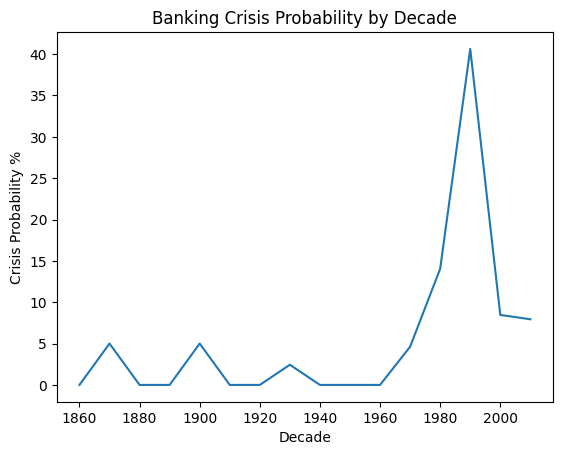

In [180]:
banking_by_decade = df.groupby('decade')['banking_crisis'].mean()*100

plt.figure()
plt.plot(banking_by_decade.index, banking_by_decade.values)
plt.title("Banking Crisis Probability by Decade")
plt.xlabel("Decade")
plt.ylabel("Crisis Probability %")
plt.show()

Debt Default Crisis

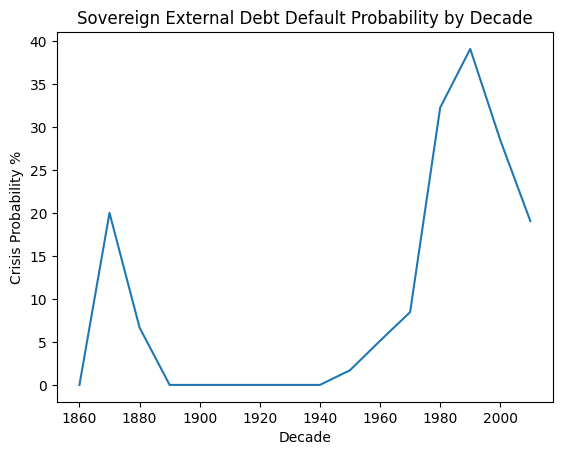

In [181]:
debt_default_by_decade = df.groupby('decade')['sovereign_external_debt_default'].mean()*100

plt.figure()
plt.plot(debt_default_by_decade.index, debt_default_by_decade.values)
plt.title("Sovereign External Debt Default Probability by Decade")
plt.xlabel("Decade")
plt.ylabel("Crisis Probability %")
plt.show()

Country's economic instability in different decades, measured by probability percentages

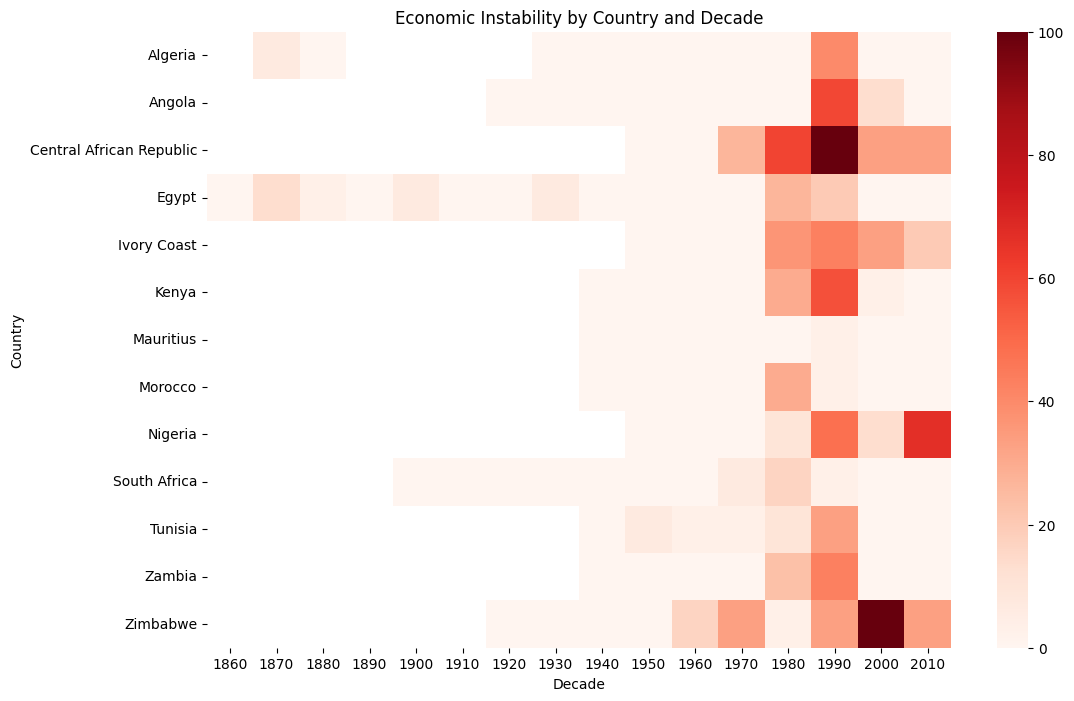

In [182]:
# Create Country × Decade Summary

country_decade = df.groupby(['country','decade'])[['banking_crisis','systemic_crisis','sovereign_external_debt_default']].mean()

country_decade = country_decade.reset_index()

# Create Composite Instability Score
country_decade['instability_score'] = (country_decade[['banking_crisis','systemic_crisis','sovereign_external_debt_default']].mean(axis=1))*100

# Create Pivot Table

pivot_instability = country_decade.pivot(index='country',columns='decade',values='instability_score')

# Plot Heatmap

plt.figure(figsize=(12,8))
sns.heatmap(pivot_instability, cmap='Reds')
plt.title("Economic Instability by Country and Decade")
plt.xlabel("Decade")
plt.ylabel("Country")
plt.show()

# Results from second business question

- Inflation spiked significantly in the 1980s-1990s.

- Banking crisis probability peaked in the 1990s.

- Sovereign default probability also peaked in the 1990s.

- The instability was broad-based across multiple crisis indicators.